In [2]:
#Importing all the necessary libraries
import pandas as pd    
import numpy as np 
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
import catboost
import matplotlib.pyplot as plt
from operator import itemgetter
import scipy
import string
import xgboost
from tqdm import tqdm
import xgbfir
from scipy import stats
from sklearn.ensemble import StackingRegressor
import optuna
import math
import itertools
import pickle
import warnings 
import seaborn as sns
import lightgbm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

global random_state
random_state = 42
warnings.filterwarnings('ignore')

In [3]:
#Reading the train dataset
df = pd.read_csv("..\\dataset\\train.csv")
df.head(2)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60


In [4]:
#Dropping the id column 
target = pd.DataFrame()
data = df.drop(['id','loss'],axis=1)
target['loss'] = df['loss']

In [5]:
#Applying normaliztion to loss column
loss_log = np.log(target['loss'] + 1)
target['normalized_log_loss'] = (loss_log-loss_log.min())/(loss_log.max()-loss_log.min())

#Log tansformation plus shifting its value by 200
target['log_200'] =  np.log(target['loss'] + 200)

#Loss tansformation
target['loss_tranform'] = target['loss']**0.25

#Loss Transformation - (1 + loss)**0.25
target['log_loss_transform'] = (1 + target['loss'])**0.25

#Log tansformation plus shifting its value by 200
target['log_100'] =  np.log(target['loss'] + 100)

#Dividing by 10
target['loss_d10'] =  10/target['loss']

#Dividing by 10 and appying log
target['log_d10'] =  np.log(10/target['loss'])

#Loss tansformation
target['loss_tranform_50'] = target['loss']**0.5

#Loss Transformation - (1 + loss)**0.50
target['log_loss_transform_50'] = np.log((1 + target['loss'])**0.50)

In [6]:
#All the decoding function which will revert back our transformed loss value to original loss value
def decode_normalized_log_loss(data):
    lmin, lmax = 0.5128236264286637, 11.703655322715969
    denormalized = data * (lmax - lmin) + lmin
    return np.exp(denormalized) - 1

def decode_log_200(data):
    return np.exp(data)-200

def decode_loss_tranform(data):
    return data**(1/float(0.25))

def decode_log_loss_transform(data):
    return data**(1/float(0.25)) - 1

def decode_log_100(data):
    return np.exp(data) - 100

def decode_loss_d10(data):
    return 10/data

def decode_log_d10(data):
    return 10/np.exp(data)

def decode_loss_tranform_50(data):
    return data**(1/float(0.50))

def decode_log_loss_transform_50(data):
    data = np.exp(data)
    return data**(1/float(0.50)) - 1

In [7]:
#Storing all the columns names
cat_name = ['cat'+str(x) for x in range(1,117)]
cont_name = ['cont'+str(x) for x in range(1,15)]

In [8]:
#Applying BOX-COX transformation to All numerical columns
for i in cont_name:
    data[i], fitted_lambda = stats.boxcox(data[i] + 1)

In [9]:
#Removing all the columns where same value is repeated for 99.9% of time
zero_variance = {}
for i in cat_name:
    val_counts = dict(data[i].value_counts())
    max_key = max(val_counts, key=val_counts.get)
    
    var = val_counts[max_key]/len(data[i].values)
    if var >= 0.999:
        zero_variance[i] = var

data = data.drop(zero_variance.keys(), axis = 1)
cat_name = [x for x in cat_name if x not in zero_variance.keys()]
drop_col = list(zero_variance.keys())
print(drop_col)

['cat15', 'cat22', 'cat55', 'cat56', 'cat62', 'cat63', 'cat64', 'cat68', 'cat70']


In [10]:
#Applying lexical encoding to all categorical data
def lexical_encoding(charcode):
    r = 0
    ln = len(str(charcode))
    for i in range(ln):
        r += (ord(str(charcode)[i]) - ord('A') + 1) * 26 ** (ln - i - 1)
    return r

#Lexical Encoding on Categorical Data
for i in tqdm(cat_name):
    data[i] = data[i].apply(lexical_encoding)

100%|██████████| 107/107 [00:18<00:00,  5.91it/s]


In [11]:
#Train_test_split using stratified binned data
#Here i have used percentile data to binned the loss data
all_bin = [np.percentile(np.abs(target['loss']),i) for i in range(0,100)]
def bin_type(value):
    for i in range(len(all_bin)):
        if value <= all_bin[i]:
            return i


target['binned'] = target['loss'].apply(np.abs).apply(bin_type).fillna(100.0)
target = target[target['binned'] != 0.0]
data = data.loc[target.index]
#Storing our train_test_split result, as stratified split always shuffle the data, so to maintain same results across all the model
#I have pickled the datat

# train_data = train_test_split(data, target, test_size=0.10, random_state=random_state,
#                                                    stratify=target['binned'])
# file = open('train_data.pkl', 'wb')
# pickle.dump(train_data, file)
# file.close()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.10, random_state=random_state, stratify=target['binned'])

In [12]:
#Loading the train_test pickle file
# file = open('train_data.pkl', 'rb')
# X_train, X_test, y_train, y_test = pickle.load(file)
# file.close()
# X_train.shape, X_test.shape

<AxesSubplot:xlabel='log_200', ylabel='Density'>

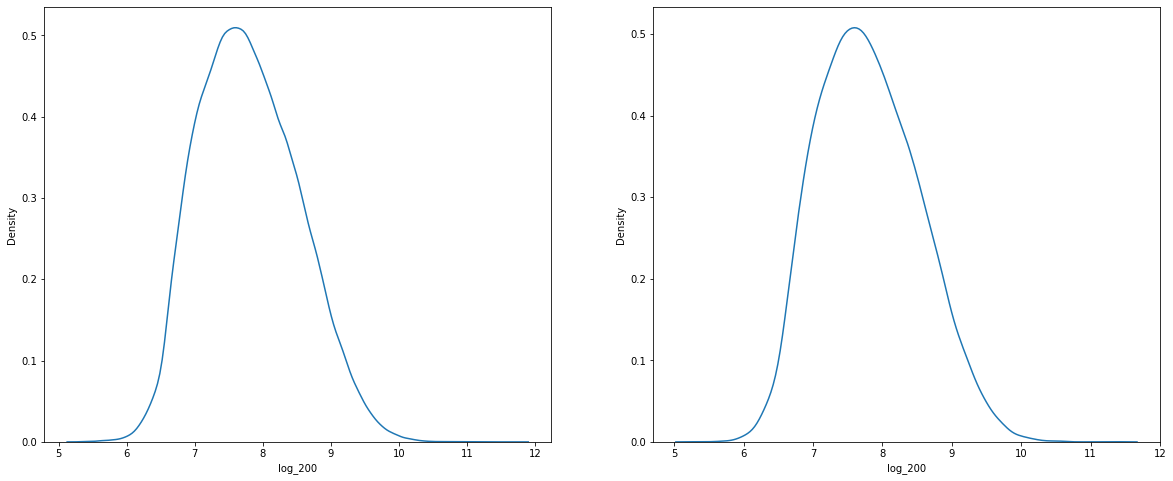

In [13]:
#Checking the distribution of train and test loss value
fig, ax = plt.subplots(1,2,figsize=(20,8))
sns.distplot(y_train['log_200'],hist=False, ax=ax[0])
sns.distplot(y_test['log_200'],hist=False, ax=ax[1])

In [14]:
#Training a XGBoost model, to retrieve two feature interaction using xgbfir library
xgb = xgboost.XGBRegressor(tree_method='gpu_hist',n_jobs=-1,random_state=random_state,seed=random_state)
xgb.fit(X_train,y_train['log_loss_transform'])
xgbfir.saveXgbFI(xgb, cat_name + cont_name, 'xgb_hist.xlsx')

In [15]:
#After testing out with various value, I have found out that using only the top 40 value from two-way feature interaction helps our xgboost model to perform better
xgb_excel = pd.read_excel('xgb_hist.xlsx',sheet_name='Interaction Depth 1')
two_way = []
for i in xgb_excel['Interaction'].values:
    temp = i.split('|')
    if 'cont' not in temp[0] and 'cont' not in temp[1]:
        two_way.append(i)
two_way = two_way[:40]

In [16]:
#Here I am concatenating and adding two way feature interaction columns
#After concatenation, I am converting all those value as int value
#Using this concatenation features, mae score of xgboost decrease quite a bit (This was confirmed using 10-fold CV and default XGBRegressor model)
data_ = data.copy()
for i in tqdm(two_way):
    features = i.split('|')
    concat_name = i.replace('|','_')
    mul_name = i.replace('|','*')
    data_[concat_name] = data_[features[0]].astype(str) + data_[features[1]].astype(str)
    data_[concat_name] = data_[concat_name].astype(int)
    data_[mul_name] = data_[features[0]].astype(float) + data_[features[1]].astype(float)

100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


In [17]:
#Defining the custom objective function for xgboost model which take cares for rmse and mae
def obj(preds, dtrain):
    labels = dtrain.get_label()
    c = 1.5
    x = preds - labels
    grad = c * x /(np.abs(x) + c)
    hess = c ** 2 / (np.abs(x) + c) ** 2
    grad_rmse = x
    hess_rmse = 1.0
    grad_mae = np.array(x)
    grad_mae[grad_mae > 0] = 1.
    grad_mae[grad_mae <= 0] = -1.
    hess_mae = 1.0
    coef = [0.7, 0.15, 0.15]
    return coef[0] * grad + coef[1] * grad_rmse + coef[2] * grad_mae, coef[0] * hess + coef[1] * hess_rmse + coef[2] * hess_mae

#Over here I am evaluating model on mse score, as it helps to reduce error on bigger loss value
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mse', mae(decode_log_loss_transform(y),decode_log_loss_transform(yhat))

In [18]:
xgb1_params = {'n_estimators': 5500,
          'max_depth': 11, 
          'min_child_weight': 100, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel': 0.55, 
          'learning_rate': 0.005, 
          'base_score': 0.9, 
          'tree_method':'gpu_hist',
          'n_jobs':-1,
          'seed':0,
          'random_state':random_state,
          'eval_metric': obj}

xgb2_params = {'n_estimators': 6000,
          'max_depth': 11, 
          'min_child_weight': 150, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel': 0.55, 
          'learning_rate': 0.005, 
          'base_score': 0.9, 
          'tree_method':'gpu_hist',
          'n_jobs':-1,
          'seed':0,
          'random_state':random_state,
          'eval_metric': obj}

xgb3_params = {'n_estimators': 5500,
          'max_depth': 11, 
          'min_child_weight': 100, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel': 0.55, 
          'learning_rate': 0.005, 
          'base_score': 0.9, 
          'tree_method':'gpu_hist',
          'n_jobs':-1,
          'seed':0,
          'random_state':random_state,
          'eval_metric': obj}

lgbm_params = {'subsample': 0.7732241782273651, 
          'colsample_bytree': 0.8208793491586571, 
          'min_child_samples': 119, 
          'n_estimators': 1664, 
          'learning_rate': 0.08833099322191373,
          'objective':'regression_l1',
          'random_state':random_state}

In [ ]:
estimator = StackingRegressor([('xgb1',xgboost.XGBRegressor(**xgb1_params)),
                               ('xgb2',xgboost.XGBRegressor(**xgb2_params)),
                               ('xgb3',xgboost.XGBRegressor(**xgb3_params)),
                               ('lgbm',lightgbm.LGBMRegressor(**lgbm_params))]
                               , final_estimator = catboost.CatBoostRegressor(),
                               passthrough=True)
estimator.fit(data_,target['log_200'])

In [56]:
#save estimator pickle file 
with open('..\\models\\estimator.pkl', 'wb') as f:
    pickle.dump(estimator, f)

In [19]:
#load estimator pickle file 
with open('..\\models\\estimator.pkl', 'rb') as f:
    estimator = pickle.load(f)

In [20]:
pred = estimator.predict(data_)
pred = [decode_log_200(x) for x in pred]
mae(target['loss'],pred)

970.0388791900697

# Test Data Submission

In [21]:
#Loading the test data
test_df = pd.read_csv("..\\dataset\\test.csv")
t_id = test_df['id']
test_df = test_df.drop(['id'], axis=1)
test_df = test_df.drop(drop_col, axis=1)
test_df.shape

(125546, 121)

In [22]:
#Preprocessing all the numerical and categorical data
for i in cont_name:
    test_df[i], fitted_lambda = stats.boxcox(test_df[i] + 1)
    
for i in tqdm(cat_name):
    test_df[i] = test_df[i].apply(lexical_encoding)

100%|██████████| 107/107 [00:12<00:00,  8.59it/s]


In [23]:
#Applying Two way feature interaction to test data
for i in tqdm(two_way):
    features = i.split('|')
    concat_name = i.replace('|','_')
    mul_name = i.replace('|','*')
    test_df[concat_name] = test_df[features[0]].astype(str) + test_df[features[1]].astype(str)
    test_df[concat_name] = test_df[concat_name].astype(int)
    test_df[mul_name] = test_df[features[0]].astype(float) + test_df[features[1]].astype(float)

100%|██████████| 40/40 [00:03<00:00, 10.48it/s]


In [24]:
test_pred = estimator.predict(test_df)
test_pred = [decode_log_200(x) for x in test_pred]

In [26]:
#Creating the submission file
sub = pd.DataFrame()
sub['id'] = t_id
sub['loss'] = test_pred
sub.head()

,id,loss
0,4,1508.816892
1,6,1975.302469
2,9,9675.214550
3,12,6235.617812
4,15,737.666754


In [27]:
sub.shape

(125546, 2)

In [28]:
sub.to_csv('..\\submission\\submission.csv', index=False)

<img src="https://i.imgur.com/f7aQOS9.png">